<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Harshit/Stage_1_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, concatenate, Dropout,MaxPool2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization,UpSampling2D, Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [2]:
im_height, im_width, im_channels = (128,128,3)
n_classes = 20

In [3]:
#Build the model
def conv_2d_block (x,n_filters,k_size,batchnorm = False):
#1st layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)
#2nd Layer
  x= Conv2D(filters=n_filters,kernel_size=(k_size,k_size) ,padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x= BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [4]:
def clothing_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c1 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p1 = MaxPool2D(pool_size=(pool_size,pool_size))(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_2d_block(p1,n_filters*2,conv_k_size,batchnorm)  
  p2 = MaxPool2D(pool_size=(pool_size,pool_size))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_2d_block(p2,n_filters*4,conv_k_size,batchnorm)  
  p3 = MaxPool2D(pool_size=(pool_size,pool_size))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv_2d_block(p3,n_filters*8,conv_k_size,batchnorm)  
  p4 = MaxPool2D(pool_size=(pool_size,pool_size))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_2d_block(p4,n_filters*16,conv_k_size,batchnorm)  
  p5 = MaxPool2D(pool_size=(pool_size,pool_size))(c5)
  p5 = Dropout(dropout)(p5)

  c6 = conv_2d_block(p5,n_filters*32,conv_k_size,batchnorm)  
  p6 = MaxPool2D(pool_size=(pool_size,pool_size))(c6)
  p6 = Dropout(dropout)(p6)

  c7 = conv_2d_block(p6,n_filters*64,conv_k_size,batchnorm)
 

  a =  tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="nearest")(c7)

  c8 = conv_2d_block(a,n_filters*32,conv_k_size,batchnorm)  


  return c8

In [5]:
def pose_encoder(inputs, n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c01 = conv_2d_block(inputs,n_filters*1,conv_k_size,batchnorm)  
  p01 = MaxPool2D(pool_size=(pool_size,pool_size))(c01)
  p01 = Dropout(dropout)(p01)
  
  c02 = conv_2d_block(p01,n_filters*2,conv_k_size,batchnorm)  
  p02 = MaxPool2D(pool_size=(pool_size,pool_size))(c02)
  p02 = Dropout(dropout)(p02)

  c03 = conv_2d_block(p02,n_filters*4,conv_k_size,batchnorm)  
  p03 = MaxPool2D(pool_size=(pool_size,pool_size))(c03)
  p03 = Dropout(dropout)(p03)

  c04 = conv_2d_block(p03,n_filters*8,conv_k_size,batchnorm)  
 

  c05 = conv_2d_block(c04,n_filters*16,conv_k_size,batchnorm)  
  

  c06 = conv_2d_block(c05,n_filters*32,conv_k_size,batchnorm)
 
  return c06

In [6]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same' )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  
  # add the input 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

In [7]:
def res_block(x, s, filters):

  # input_im = Input(shape=(x.shape[1], x.shape[2], x.shape[3])) # cifar 10 images size
  # x = ZeroPadding2D(padding=(3, 3))(input_im)

  # # 1st stage
  # # here we perform maxpooling, see the figure above

  # x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)


  #2nd stage 
  # frm here on only conv block and identity block, no pooling
  x = res_conv(x, s, filters)
  x = res_identity(x, filters=(64, 512))
  x = res_identity(x, filters=(64, 512))

  # 3rd stage

  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))


  # 4th stage

  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))
  x = res_identity(x, filters=(256, 512))

  # 5th stage

  x = res_identity(x, filters=(512, 512))
  x = res_identity(x, filters=(512, 512))

  # ends with average pooling and dense connection

  # x = AveragePooling2D((2, 2), padding='same')(x)

  # x = Flatten()(x)
  # x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  return x

In [8]:
#cloth decoder 
def clothing_decoder(inputs,n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):
  u6 = Conv2DTranspose(filters=n_filters *16 ,kernel_size=(3,3), strides=(2,2),padding='same')(inputs)
  u6 = Dropout(dropout)(u6)
  c7 = conv_2d_block(u6,n_filters *16 , conv_k_size,batchnorm)

  u7 = Conv2DTranspose(filters=n_filters *8,kernel_size=(3,3), strides=(2,2),padding='same')(c7)
  u7 = Dropout(dropout)(u7)
  c8 = conv_2d_block(u7,n_filters *8 , conv_k_size,batchnorm)

  u8 = Conv2DTranspose(filters=n_filters *4,kernel_size=(3,3), strides=(2,2),padding='same')(c8)
  u8 = Dropout(dropout)(u8)
  c9 = conv_2d_block(u8,n_filters *4, conv_k_size,batchnorm)

  c10 = Conv2D(filters=n_classes, kernel_size=(1,1),activation='softmax')(c9)
  
  return c10

In [9]:
def warp(cloth_input, pose_input):
    cloth = clothing_encoder(cloth_input)
    pose = pose_encoder(pose_input)
    both = concatenate([cloth, pose])
    resnet = res_block(both, 1, (64,512))
    output = clothing_decoder(resnet)

    return Model(inputs = (cloth_input, pose_input), outputs = output, name = "Warping_Module")

In [10]:
cloth = Input((im_height, im_width, n_classes), name = "cloth")
pose = Input((im_height, im_width, im_channels), name = 'pose')
test = warp(cloth, pose)

In [11]:
test.summary()

Model: "Warping_Module"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cloth (InputLayer)              [(None, 128, 128, 20 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 2896        cloth[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [12]:
x_train_pos = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/pos_train.npy")
x_train_seg = np.load("/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/seg_train_argmax.npy")

In [13]:
x_train_seg_1 = tf.one_hot(x_train_seg, depth = n_classes)

In [51]:
IMG_SIZE = 128

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#   tf.keras.layers.experimental.preprocessing.RandomCrop(0.2,0.2)
])

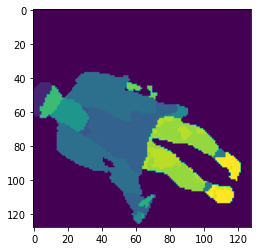

In [54]:
# plt.imshow(tf.math.argmax(data_augmentation(x_train_seg_1[10:11])[0], axis = -1))

In [55]:
def preprocessing(pos, seg):
    seg_1 = data_augmentation(seg)
    return (seg, pos), seg_1

In [56]:
train = tf.data.Dataset.from_tensor_slices((x_train_pos, x_train_seg_1))
train = train.batch(8).repeat()
train = train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<ParallelMapDataset shapes: (((None, 384, 256, 20), (None, 384, 256, 3)), (None, 128, 128, 20)), types: ((tf.float32, tf.float32), tf.float32)>

In [ ]:
optimizer = 'Adam'
loss = 'CategoricalCrossentropy'
metrics = ['accuracy']

test.compile(optimizer = optimizer, loss = loss, metrics = metrics)

(1, 128, 128, 20)